# Abstract
In 2001, Warren Buffett claimed that the total US equity market capitalization to GDP ratio served as "the best single measure of where valuations stand at any given moment." Since that claim, this ratio has been famously coined the Buffett Ratio. While the Buffett Ratio is intuitive and prior literature suggests that a statistically-dyanmic decision rule yields significant predictive power, I further test this hypothesis under the context of a mean-reversion based alpha generation strategy. Moreover, I extend prior literature by comparing the aforementioned results to other proxies for market over/undervaluation. Namely, I use the yield spread between Moody's seasoned Baa Corporate Bond and the 10-year treasury. I find that using the Buffett Indicator on a simple strategy yields a sharpe of 1.53 and it does significantly better than using the yield spread. This implies more research could be warranted in this area and the signal has potential.

# Review of Existing Literature

My work has a two-fold contribution to prior literature.

Firstly, though popular amongst retail investors, the Buffett Indicator doesn't have a wide array of precusor background in finance literature. Most recent and interesting work (in my opinion) includes Lleo and Ziemba (2017), which finds that a static decision rule (as suggested by Warren Buffett) does not lead to a large amount of predictive power; however, a time-varying approach works much better and is statistically significant up to a 1% cutoff. Moreover, Chang and Pak (2017) finds superlinear relationships between the Buffett Indicator and GNP across different countries, implying that the indicator could be used to find relative valuation flaws across international economies.

Secondly, and perhaps more importantly, this work contributes to the broader literature of equity market corrections. Especially after the 2008 financial crisis, this is a topic that's been prevelant amongst finance and accounting literature. At the same time, varying perspectives are explored. To illustrate some examples that aren't "traditional," Lewis et. al (2010) explore the social and ethical implications of the 2008 financial crisis. Cornell and Damodaran (2019) - and yes, this is the one and only Aswath Damodaran, NYU's Dean of Valuation - extended equity market corrections to the venture capital space. On a more quantitative note, Pelsser (2003) looks at corrections due to misvaluation in the form of Convexity Correction. For those unaware, this is a phenomenon that arises due to the non-linear relationship between fixed-income yields and prices. This causes derivatives (usually forwards) to adjust their interest rates/yield.

The bottom line is that an array of finance literature explores market corrections due to misvaluation, and a small subset of it addresses the Buffett Indicator. To my knowledge, there is no literature that attempts to compare the Buffett Indicator's predictive power to other "common" indicators, such as yield spreads.

# Data Collection

Luckily, the data required to address my problem statement was widely available via common API calls to yfinance. I did have to collect the following datasets: (1) Buffett Indicator over time (Wilshire 5000/US GDP) and (2) Moody's seasoned Baa Corporate Bond v 10 year treasury spread. The economic datasets were retrieved in csv format from the Federal Reserve Bank of St. Louis' Economic Research page. I do some standard data cleaning.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read all the csv files
# Extra data was imported for future work
ten_year = pd.read_csv('DGS10.csv')
three_month = pd.read_csv('DGS3MO.csv')
gnp = pd.read_csv('GNP.csv')
yield_spread = pd.read_csv('BAA10Y.csv')
SPX_prices = pd.read_csv('SPX.csv')

# Methodology
My methodology is (relatively) simple. I start by creating a baseline model with the yield spread data then move to the Buffett Indicator. This "model" is not really a model that's learned but more of an algorithm. The algorithm buys/shorts a proxy for the market - in my case the SPY whenever our signal is outside some probability of occurance assuming a Gaussian distribution defined by the rolling statistics over a simple moving average. This is mostly in line with that suggested by Lleo and Ziemba (2017).

# Yield Spread

In [3]:
SPX_prices = SPX_prices.rename(columns={'Date': 'DATE'})
SPX_prices['DATE'] = pd.to_datetime(SPX_prices['DATE'], format="%Y-%m-%d")
SPX_prices = SPX_prices.sort_values(by='DATE').reset_index(drop=True)
SPX_prices.head()

,DATE,Open,High,Low,Close,Adj Close,Volume
0,1986-01-02,211.279999,211.279999,208.929993,209.589996,209.589996,98960000
1,1986-01-03,209.589996,210.880005,209.509995,210.880005,210.880005,105000000
2,1986-01-06,210.880005,210.979996,209.929993,210.649994,210.649994,99610000
3,1986-01-07,210.649994,213.800003,210.649994,213.800003,213.800003,153000000
4,1986-01-08,213.800003,214.570007,207.490005,207.970001,207.970001,180300000


In [4]:
# Convert all dates to datetime objects and all numbers to floats
for df in [ten_year, three_month, gnp, yield_spread]:
    df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
    column = df.columns[1]
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [5]:
# Drop NA values
yield_spread = yield_spread.dropna()

In [6]:
# Define function for simple moving average using last week
def add_sma_weekly(df):
    df['SMA_weekly'] = df.iloc[:,1].rolling(window=5).mean()
    df['SMA_weekly_SD'] = df.iloc[:,1].rolling(window=5).std()

# Define function for simple moving average using last month
def add_sma_monthly(df):
    df['SMA_monthly'] = df.iloc[:,1].rolling(window=22).mean()
    df['SMA_monthly_SD'] = df.iloc[:,1].rolling(window=22).std()
    
# Define function for simple moving average using last quarter
def add_sma_quarterly(df):
    df['SMA_quarterly'] = df.iloc[:,1].rolling(window=65).mean()
    df['SMA_quarterly_SD'] = df.iloc[:,1].rolling(window=65).std()

In [7]:
# Add SMA
add_sma_weekly(yield_spread)
add_sma_monthly(yield_spread)
add_sma_quarterly(yield_spread)

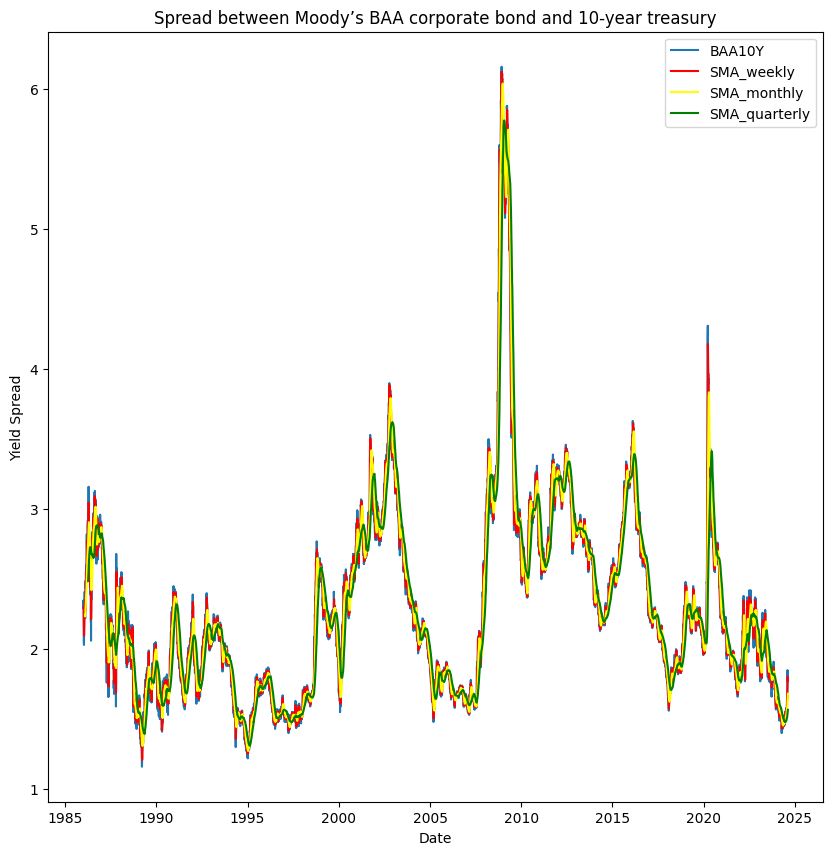

In [8]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.xlabel('Date')
plt.ylabel('Yield Spread')
plt.title('Spread between Moody’s BAA corporate bond and 10-year treasury')
plt.plot(yield_spread['DATE'],yield_spread['BAA10Y'], label = "BAA10Y")
plt.plot(yield_spread['DATE'], yield_spread['SMA_weekly'], label ="SMA_weekly", color = "red")
plt.plot(yield_spread['DATE'], yield_spread['SMA_monthly'], label ="SMA_monthly", color = "yellow")
plt.plot(yield_spread['DATE'], yield_spread['SMA_quarterly'], label ="SMA_quarterly", color = "green")
plt.legend()
plt.show()

In [9]:
# Function that calculates zscores
def zscores(df):
    column = df.columns[1]
    df['zscore_weekly'] = (df[column] - yield_spread['SMA_weekly']) / yield_spread['SMA_weekly_SD']
    df['zscore_monthly'] = (df[column] - yield_spread['SMA_monthly']) / yield_spread['SMA_monthly_SD']
    df['zscore_quarterly'] = (df[column] - yield_spread['SMA_quarterly']) / yield_spread['SMA_quarterly_SD']
zscores(yield_spread)

In [10]:
# Plots with cutoffs for 2 SDs above or below
def plot_zscore(df, zcolumn):
    plt.plot(yield_spread['DATE'], yield_spread[zcolumn])
    plt.axhline(y=0, color='r', linestyle='-')
    plt.axhline(y=2, color='r', linestyle='--')
    plt.axhline(y=-2, color='r', linestyle='--')

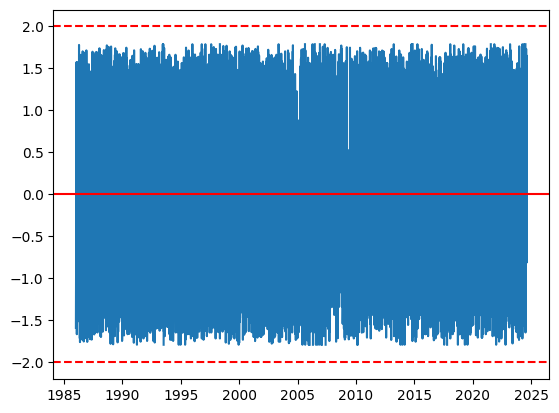

In [11]:
plot_zscore(yield_spread, 'zscore_weekly')

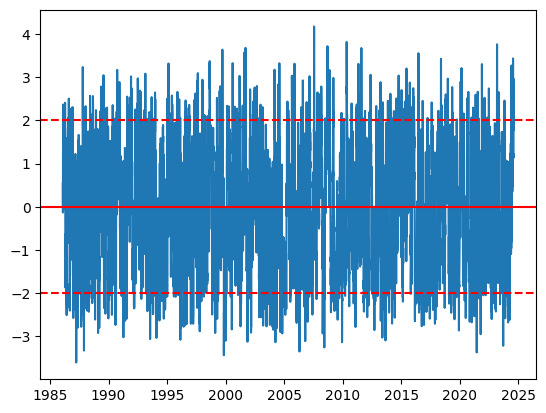

In [12]:
plot_zscore(yield_spread, 'zscore_monthly')

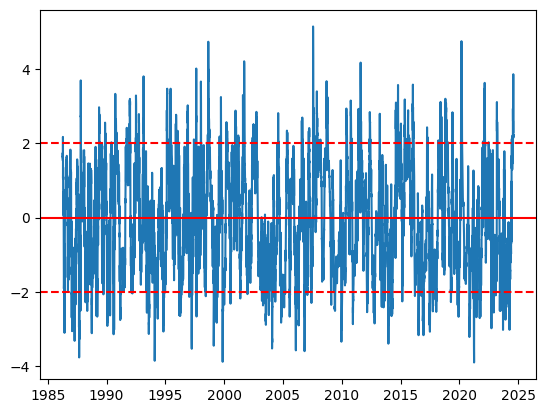

In [13]:
plot_zscore(yield_spread, 'zscore_quarterly')

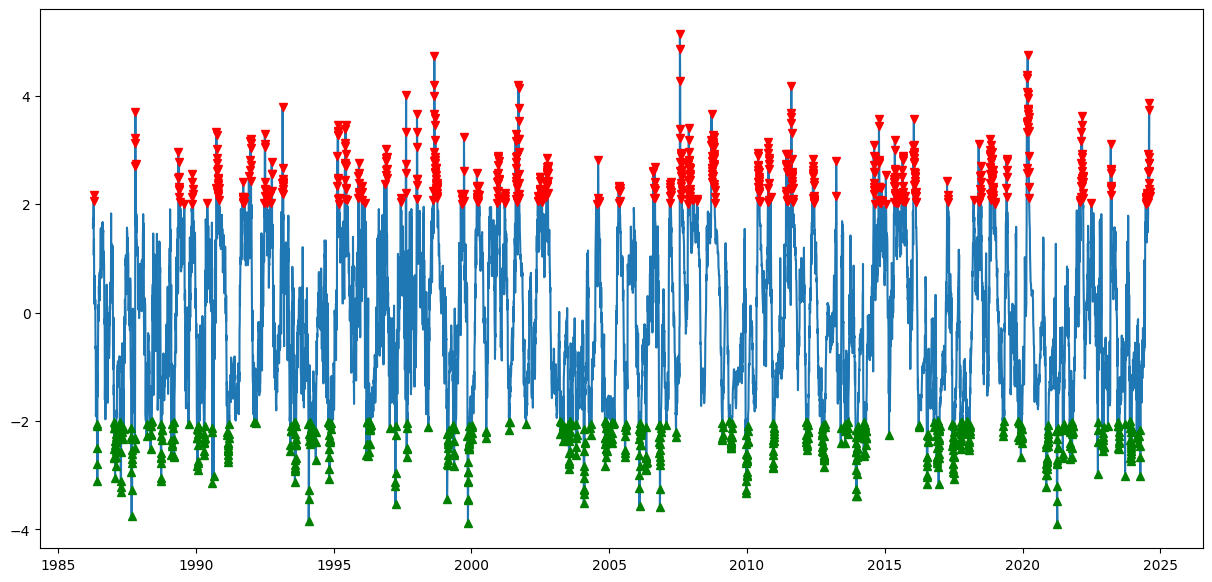

In [14]:
# Generate signals according to trading strategy described above
a = 'zscore_quarterly'
buy_signal = yield_spread.where(yield_spread[a]<-2).dropna()
sell_signal = yield_spread.where(yield_spread[a]>2).dropna()

# Create Sell Signal by filtering for zscore greater than 1
plt.figure(figsize=(15,7))
plt.plot(yield_spread['DATE'], yield_spread[a])
plt.plot(buy_signal['DATE'], buy_signal[a], linestyle='None', marker='^', color='g')
plt.plot(sell_signal['DATE'], sell_signal[a], linestyle='None', marker='v', color='r')

In [15]:
SPX_prices.head(3)

,DATE,Open,High,Low,Close,Adj Close,Volume
0,1986-01-02,211.279999,211.279999,208.929993,209.589996,209.589996,98960000
1,1986-01-03,209.589996,210.880005,209.509995,210.880005,210.880005,105000000
2,1986-01-06,210.880005,210.979996,209.929993,210.649994,210.649994,99610000


In [16]:
yield_spread.tail(5)

,DATE,BAA10Y,SMA_weekly,SMA_weekly_SD,SMA_monthly,SMA_monthly_SD,SMA_quarterly,SMA_quarterly_SD,zscore_weekly,zscore_monthly,zscore_quarterly
10069,2024-08-07,1.80,1.788,0.050695,1.642727,0.091192,1.547077,0.091391,0.236709,1.724629,2.767493
10070,2024-08-08,1.78,1.802,0.028636,1.652727,0.093716,1.551846,0.095310,-0.768273,1.358069,2.393802
10071,2024-08-09,1.77,1.796,0.032094,1.662273,0.094513,1.556769,0.098188,-0.810130,1.139816,2.171649
10072,2024-08-12,1.78,1.782,0.010954,1.671364,0.095832,1.561538,0.101385,-0.182574,1.133613,2.154779
10073,2024-08-13,1.80,1.786,0.013416,1.681364,0.097311,1.566462,0.105066,1.043498,1.219143,2.222780


In [17]:
yield_spread_copy = yield_spread
yield_spread_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9656 entries, 0 to 10073
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATE              9656 non-null   datetime64[ns]
 1   BAA10Y            9656 non-null   float64       
 2   SMA_weekly        9652 non-null   float64       
 3   SMA_weekly_SD     9652 non-null   float64       
 4   SMA_monthly       9635 non-null   float64       
 5   SMA_monthly_SD    9635 non-null   float64       
 6   SMA_quarterly     9592 non-null   float64       
 7   SMA_quarterly_SD  9592 non-null   float64       
 8   zscore_weekly     9635 non-null   float64       
 9   zscore_monthly    9635 non-null   float64       
 10  zscore_quarterly  9592 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 905.2 KB


In [18]:
# Elementary trading strategy for testing yield
money = 1000
count = 0
trades = []
short_trades = 0
long_trades = 0
short_trade_transacation_volume = 0
long_trade_transacation_volume = 0

for i in range(len(yield_spread_copy)):
    # Sell short if the z-score is > 2
    if yield_spread_copy['zscore_quarterly'].iloc[i] > 2:
        money += SPX_prices['Close'].iloc[i]
        count -= 1
        short_trade_transacation_volume += SPX_prices['Close'].iloc[i]
        short_trades += 1
    # Buy long if the z-score is < 2
    elif yield_spread_copy['zscore_quarterly'].iloc[i] < -2:
        money -= SPX_prices['Close'].iloc[i]
        count += 1
        long_trade_transacation_volume += SPX_prices['Close'].iloc[i]
        long_trades +=1
    # Clear positions if the z-score between -.5 and .5
    elif abs(yield_spread_copy['zscore_quarterly'].iloc[i]) < 0.25:
        cycle_volume = count*SPX_prices['Close'].iloc[i]
        if cycle_volume != 0:
            if short_trade_transacation_volume > 0:
                cycle_profit_loss = short_trade_transacation_volume - cycle_volume
                trades.append(cycle_profit_loss/short_trade_transacation_volume)
                short_trade_transacation_volume = 0
            elif long_trade_transacation_volume > 0:
                cycle_profit_loss = cycle_volume - long_trade_transacation_volume
                trades.append(cycle_profit_loss/long_trade_transacation_volume)
                long_trade_transacation_volume = 0
        money += cycle_volume
        count = 0

In [19]:
yield_sharpe = (np.mean(trades) - 0.0163)/np.std(trades)
yield_sharpe

np.float64(0.7951509165910967)

# Buffet Indicator

In [20]:
BI = pd.read_csv('W5000GDP.csv')
BI.head()

,DateTime,Wilshire 5000 to GDP Ratio
0,1971-01-01,73.387807
1,1971-04-01,80.005739
2,1971-07-01,78.080586
3,1971-10-01,76.564116
4,1972-01-01,77.256762


In [21]:
BI.columns

Index(['DateTime', 'Wilshire 5000 to GDP Ratio'], dtype='object')

In [22]:
BI = BI.rename(columns={'DateTime':'DATE', 'Wilshire 5000 to GDP Ratio':'INDICATOR'})
BI['DATE'] = pd.to_datetime(BI['DATE'])
BI.head()

,DATE,INDICATOR
0,1971-01-01,73.387807
1,1971-04-01,80.005739
2,1971-07-01,78.080586
3,1971-10-01,76.564116
4,1972-01-01,77.256762


In [23]:
BI = BI.dropna()
BI

,DATE,INDICATOR
0,1971-01-01,73.387807
1,1971-04-01,80.005739
2,1971-07-01,78.080586
3,1971-10-01,76.564116
4,1972-01-01,77.256762
...,...,...
210,2023-07-01,162.714306
211,2023-10-01,154.411329
212,2024-01-01,169.723165
213,2024-04-01,182.762758


In [24]:
def add_sma_weekly(df,period,period_in_string):
    a = df['SMA_'+period_in_string+'_qtrs'] = df.iloc[:,1].rolling(window=period).mean()
    b = df['SMA_'+period_in_string+'_qtrs_SD'] = df.iloc[:,1].rolling(window=period).std()
    column = df.columns[1]
    df['zscore'+period_in_string+'_qtrs'] = (df[column] - a) / b

add_sma_weekly(BI,2,'2')
add_sma_weekly(BI,4,'4')
add_sma_weekly(BI,12,'12')

In [25]:
column = BI.columns[1]
column

'INDICATOR'

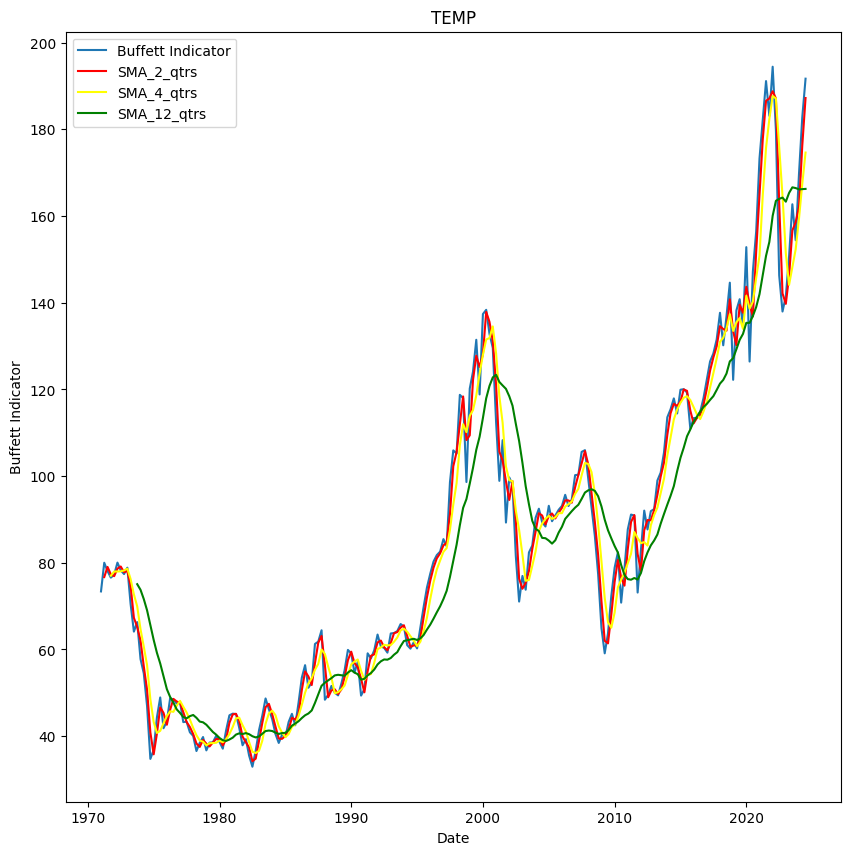

In [26]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.xlabel('Date')
plt.ylabel('Buffett Indicator')
plt.title('TEMP')
plt.plot(BI['DATE'],BI['INDICATOR'], label = "Buffett Indicator")
plt.plot(BI['DATE'], BI['SMA_2_qtrs'], label = "SMA_2_qtrs", color = "red")
plt.plot(BI['DATE'], BI['SMA_4_qtrs'], label = "SMA_4_qtrs", color = "yellow")
plt.plot(BI['DATE'], BI['SMA_12_qtrs'], label = "SMA_12_qtrs", color = "green")
plt.legend()
plt.show()

In [27]:
def plot_zscore(df, zcolumn):
    plt.plot(df['DATE'], df[zcolumn])
    plt.axhline(y=0, color='r', linestyle='-')
    plt.axhline(y=1, color='r', linestyle='--')
    plt.axhline(y=-1, color='r', linestyle='--')

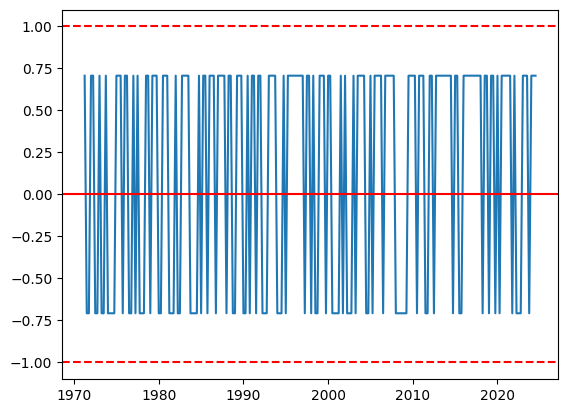

In [28]:
plot_zscore(BI, 'zscore2_qtrs')

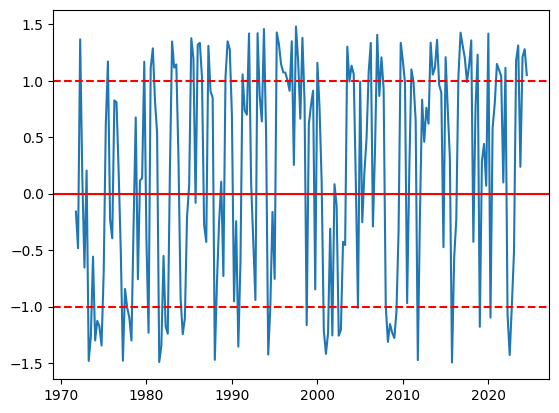

In [29]:
plot_zscore(BI, 'zscore4_qtrs')

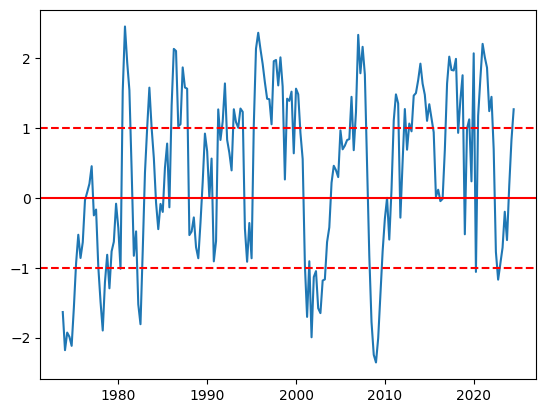

In [30]:
plot_zscore(BI, 'zscore12_qtrs')

In [31]:
def buy_sell_indicator(df,zscore_column,SD):
    buy_signal = df.where(df[zscore_column]<-SD).dropna()
    sell_signal = df.where(df[zscore_column]>SD).dropna()
    plt.figure(figsize=(15,7))
    plt.plot(df['DATE'], df[zscore_column])
    plt.plot(buy_signal['DATE'], buy_signal[zscore_column], linestyle='None', marker='^', color='g')
    plt.plot(sell_signal['DATE'], sell_signal[zscore_column], linestyle='None', marker='v', color='r')

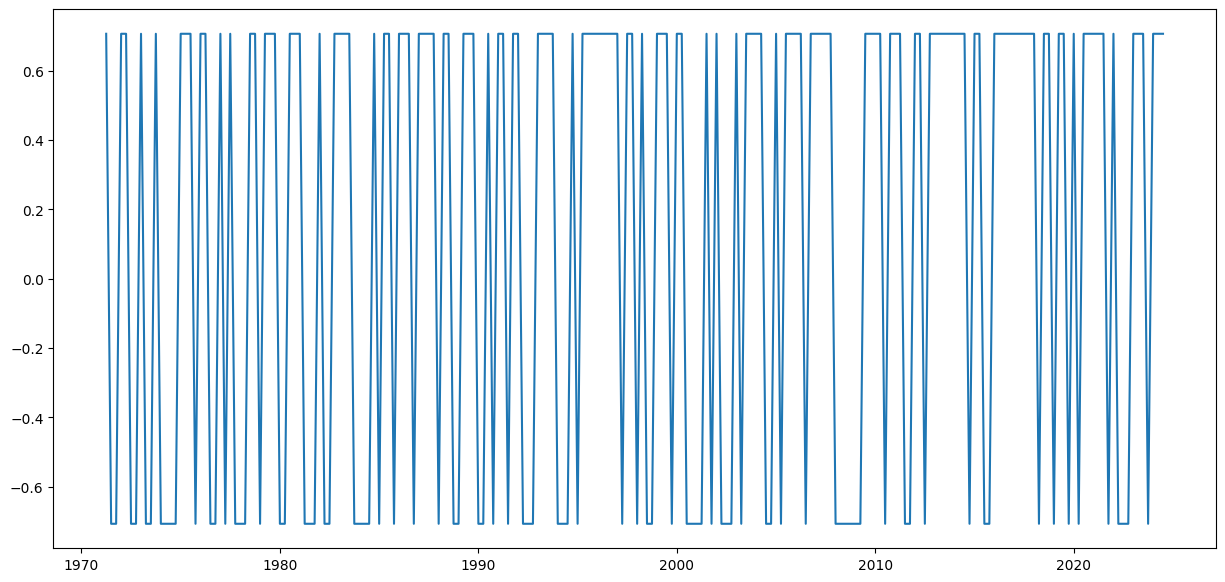

In [32]:
buy_sell_indicator(BI,'zscore2_qtrs',1)

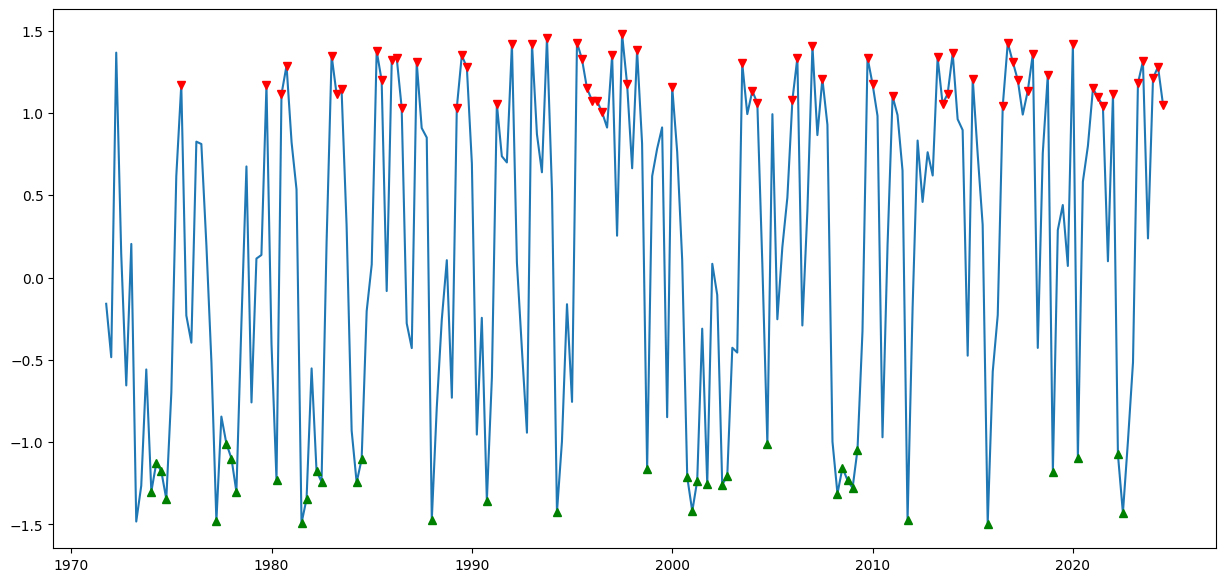

In [33]:
buy_sell_indicator(BI,'zscore4_qtrs',1)

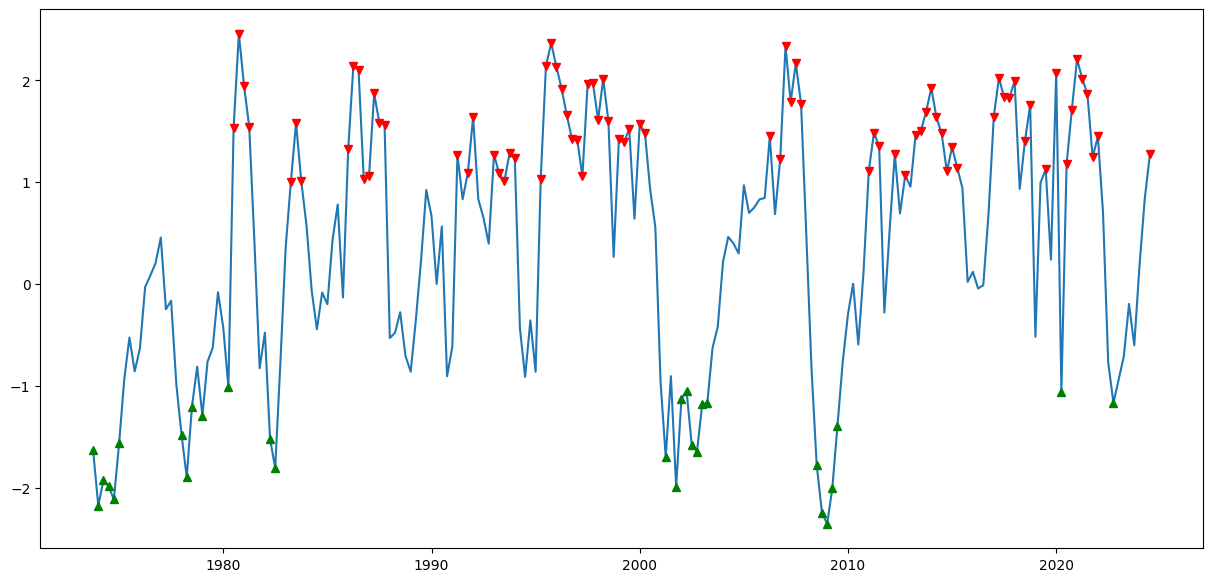

In [34]:
buy_sell_indicator(BI,'zscore12_qtrs',1)

In [35]:
# Dataset starts on 1st Jan 1971
BI.head(2)

,DATE,INDICATOR,SMA_2_qtrs,SMA_2_qtrs_SD,zscore2_qtrs,SMA_4_qtrs,SMA_4_qtrs_SD,zscore4_qtrs,SMA_12_qtrs,SMA_12_qtrs_SD,zscore12_qtrs
0,1971-01-01,73.387807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1971-04-01,80.005739,76.696773,4.679584,0.707107,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# Dataset starts on 2nd Jan 1986
SPX_prices.head(2)

,DATE,Open,High,Low,Close,Adj Close,Volume
0,1986-01-02,211.279999,211.279999,208.929993,209.589996,209.589996,98960000
1,1986-01-03,209.589996,210.880005,209.509995,210.880005,210.880005,105000000


In [37]:
# Need same start date for backtesting
BI_trim = BI.where(BI['DATE']>'1986-01-01').dropna()
BI_trim.head()

,DATE,INDICATOR,SMA_2_qtrs,SMA_2_qtrs_SD,zscore2_qtrs,SMA_4_qtrs,SMA_4_qtrs_SD,zscore4_qtrs,SMA_12_qtrs,SMA_12_qtrs_SD,zscore12_qtrs
61,1986-04-01,53.462751,50.595639,4.054709,0.707107,47.210838,4.681136,1.335555,44.166616,4.351684,2.136216
62,1986-07-01,56.378482,54.920617,2.061733,0.707107,50.019607,6.163164,1.031755,44.807159,5.494096,2.106138
63,1986-10-01,51.166423,53.772452,3.685483,-0.707107,52.184046,3.656756,-0.278286,45.220508,5.787671,1.027342
64,1987-01-01,52.397907,51.782165,0.870791,0.707107,53.351391,2.225526,-0.428431,45.926856,6.122311,1.056962
65,1987-04-01,61.269333,56.833620,6.273045,0.707107,55.303036,4.557215,1.309198,47.658923,7.274373,1.871008


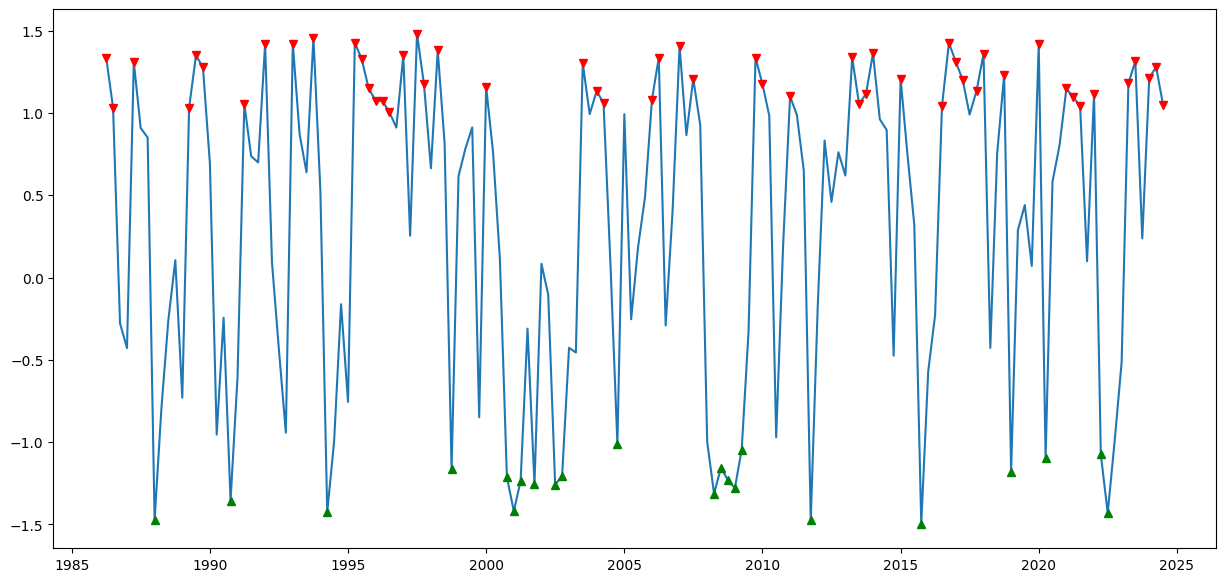

In [38]:
buy_sell_indicator(BI_trim,'zscore4_qtrs',1)

In [39]:
# Elementary trading strategy for testing yield

type = 'zscore4_qtrs'
money = 1000
count = 0
trades = []
SD = 1
short_trades = 0
long_trades = 0
short_trade_transacation_volume = 0
long_trade_transacation_volume = 0
for i in range(len(BI_trim)):
    # Sell short if the z-score is > 2
    if BI_trim[type].iloc[i] > SD:
        money += SPX_prices['Close'].iloc[i]
        count -= 1
        short_trade_transacation_volume += SPX_prices['Close'].iloc[i]
        short_trades += 1
    # Buy long if the z-score is < 2
    elif BI_trim[type].iloc[i] < -SD:
        money -= SPX_prices['Close'].iloc[i]
        count += 1
        long_trade_transacation_volume += SPX_prices['Close'].iloc[i]
        long_trades +=1
    # Clear positions if the z-score between -.25 and .25
    elif abs(BI_trim[type].iloc[i]) < 0.25:
        cycle_volume = count*SPX_prices['Close'].iloc[i]
        if cycle_volume != 0:
            if short_trade_transacation_volume > 0:
                cycle_profit_loss = short_trade_transacation_volume - cycle_volume
                trades.append(cycle_profit_loss/short_trade_transacation_volume)
                short_trade_transacation_volume = 0
            elif long_trade_transacation_volume > 0:
                cycle_profit_loss = cycle_volume - long_trade_transacation_volume
                trades.append(cycle_profit_loss/long_trade_transacation_volume)
                long_trade_transacation_volume = 0
        money += cycle_volume
        count = 0

In [40]:
buffett_sharpe = (np.mean(trades) - 0.0164)/np.std(trades)
buffett_sharpe

np.float64(1.530027824214349)

In [41]:
# Trading with profit taking:
# Elementary trading strategy for testing yield

type = 'zscore4_qtrs'
money = 1000
count = 0
trades = []
SD = 0.7
short_trades = 0
long_trades = 0
short_trade_transacation_volume = 0
long_trade_transacation_volume = 0

for i in range(len(BI_trim)):
    # Sell short if the z-score is > 2
    if BI_trim[type].iloc[i] > SD:
        money += SPX_prices['Close'].iloc[i]
        count -= 1
        short_trade_transacation_volume += SPX_prices['Close'].iloc[i]
        short_trades += 1
    # Buy long if the z-score is < 2
    elif BI_trim[type].iloc[i] < -SD:
        money -= SPX_prices['Close'].iloc[i]
        count += 1
        long_trade_transacation_volume += SPX_prices['Close'].iloc[i]
        long_trades +=1
    # clear positions if transaction volume changes by more than 10%
    elif (((abs(short_trade_transacation_volume) >= 1.1*(count*SPX_prices['Close'].iloc[i])) or (abs(short_trade_transacation_volume) <= 0.9*(count*SPX_prices['Close'].iloc[i]))) and short_trade_transacation_volume!=0):
        cycle_volume = count*SPX_prices['Close'].iloc[i]
        cycle_profit_loss = short_trade_transacation_volume - cycle_volume
        trades.append(cycle_profit_loss/short_trade_transacation_volume)
        short_trade_transacation_volume = 0
        money += cycle_volume
        count = 0
    elif (((abs(long_trade_transacation_volume) >= 1.1*(count*SPX_prices['Close'].iloc[i])) or (abs(long_trade_transacation_volume) <= 0.9*(count*SPX_prices['Close'].iloc[i]))) and long_trade_transacation_volume!=0):
        cycle_volume = count*SPX_prices['Close'].iloc[i]
        cycle_profit_loss = cycle_volume - long_trade_transacation_volume
        trades.append(cycle_profit_loss/long_trade_transacation_volume)
        long_trade_transacation_volume = 0
        money += cycle_volume
        count = 0

In [42]:
risk_val = np.std(trades)
return_val = np.mean(trades)
fixed_buffett_sharpe = (return_val - 0.0163)/risk_val
fixed_buffett_sharpe

np.float64(0.9016229167546953)

In [43]:
def trading_backtest(SD,zscore_column,profit_taking):
    type = zscore_column
    money = 1000
    count = 0
    trades = []
    short_trades = 0
    long_trades = 0
    short_trade_transacation_volume = 0
    long_trade_transacation_volume = 0
    for i in range(len(BI_trim)):
        if BI_trim[type].iloc[i] > SD:
            money += SPX_prices['Close'].iloc[i]
            count -= 1
            short_trade_transacation_volume += SPX_prices['Close'].iloc[i]
            short_trades += 1
        # Buy long if the z-score is < 2
        elif BI_trim[type].iloc[i] < -SD:
            money -= SPX_prices['Close'].iloc[i]
            count += 1
            long_trade_transacation_volume += SPX_prices['Close'].iloc[i]
            long_trades +=1
        # Clear positions if the z-score between -.5 and .5
        # clear positions if transaction volume changes by more than 10%
        elif (((abs(short_trade_transacation_volume) >=(1+profit_taking)*(count*SPX_prices['Close'].iloc[i])) or (abs(short_trade_transacation_volume) <= (1-profit_taking)*(count*SPX_prices['Close'].iloc[i]))) and short_trade_transacation_volume!=0):
            cycle_volume = count*SPX_prices['Close'].iloc[i]
            cycle_profit_loss = short_trade_transacation_volume - cycle_volume
            trades.append(cycle_profit_loss/short_trade_transacation_volume)
            short_trade_transacation_volume = 0
            money += cycle_volume
            count = 0
        elif (((abs(long_trade_transacation_volume) >= (1+profit_taking)*(count*SPX_prices['Close'].iloc[i])) or (abs(long_trade_transacation_volume) <= (1-profit_taking)*(count*SPX_prices['Close'].iloc[i]))) and long_trade_transacation_volume!=0):
            cycle_volume = count*SPX_prices['Close'].iloc[i]
            cycle_profit_loss = cycle_volume - long_trade_transacation_volume
            trades.append(cycle_profit_loss/long_trade_transacation_volume)
            long_trade_transacation_volume = 0
            money += cycle_volume
            count = 0
    risk_val = np.std(trades)
    return_val = np.mean(trades)
    sharpe = (return_val - 0.0163)/risk_val
    print('sharpe:', sharpe)
    print('SD:', SD)

In [44]:
[trading_backtest(1.05,'zscore12_qtrs',i/100) for i in range(3, 9)]
#1.05SD with 0.04 profit taking generates highest sharpe (1.18) for zscore12_qtrs


sharpe: 1.4791445043692255
SD: 1.05
sharpe: 1.6024665998791827
SD: 1.05
sharpe: 0.6927123920249736
SD: 1.05
sharpe: 0.6927123920249736
SD: 1.05
sharpe: 0.6927123920249736
SD: 1.05
sharpe: 0.6927123920249736
SD: 1.05


[None, None, None, None, None, None]

# Results

Yield Spread Sharpe: 0.79

Mean Reversion Buffett Indicator Sharpe: 1.57

Fixed Profit Taking Buffett Indicator: 1.47

# Conclusion
The main takeaways is as follows:
1. Buffett Ratio kinda works with a simple strategy, does better than the yield spread
2. I have shown that there is potential for further research in this area
3. Granularity is really not the end all be all

Next steps would include: 
1. Get a lot of compute and actually figure out the best hyperparameters
2. Experiment with different types of moving averages 
3. Use a probablistic allocation of capital
4. Only look at BI when it's overvalued/define a different distribution (not normal/lognormal)